# Use the PVOutput API library to retrieve metadata for all available systems in a given geography

**Jamie Taylor**

**2021-11-16**

## Setup

In [1]:
import sys
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

sys.path.append("..")
from pvoutput.grid_search import GridSearch
from pvoutput import PVOutput

In [2]:
plt.rcParams['figure.dpi'] = 200

In [3]:
api_key = None
system_id = None
pv = PVOutput(api_key, system_id)

In [4]:
CACHE_DIR = "/tmp"

## Generate the search grid

We first create an instance of the `GridSearch` class, specifying a directory to use for caching of boundary files:

In [5]:
grd = GridSearch(cache_dir=CACHE_DIR)

We'll use the `GridSearch.generate_grid()` method to generate a grid of lat/lon co-ordinates using hexagonal tiling, such that the 25km search radius covers the whole region of interest.

Note that too get a list of valid country names that can be used with the `generate_gird()` method, we can call:

In [6]:
grd.nat_earth.list_countries()

Available countries are:
Afghanistan, Akrotiri, Albania, Algeria, American Samoa, Andorra, Angola, Anguilla, Antarctica, Antigua and Barb., Argentina, Armenia, Aruba, Ashmore and Cartier Is., Australia, Austria, Azerbaijan, Bahamas, Bahrain, Baikonur, Bajo Nuevo Bank, Bangladesh, Barbados, Belarus, Belgium, Belize, Benin, Bermuda, Bhutan, Bir Tawil, Bolivia, Bosnia and Herz., Botswana, Br. Indian Ocean Ter., Brazil, Brazilian I., British Virgin Is., Brunei, Bulgaria, Burkina Faso, Burundi, Cabo Verde, Cambodia, Cameroon, Canada, Cayman Is., Central African Rep., Chad, Chile, China, Clipperton I., Colombia, Comoros, Congo, Cook Is., Coral Sea Is., Costa Rica, Croatia, Cuba, Curaçao, Cyprus, Cyprus U.N. Buffer Zone, Czechia, Côte d'Ivoire, Dem. Rep. Congo, Denmark, Dhekelia, Djibouti, Dominica, Dominican Rep., Ecuador, Egypt, El Salvador, Eq. Guinea, Eritrea, Estonia, Ethiopia, Faeroe Is., Falkland Is., Fiji, Finland, Fr. Polynesia, Fr. S. Antarctic Lands, France, Gabon, Gambia, Georgia,

### Search Grid Example 1

In this example, we'll generate a grid covering mainland Great Britain, using a bounding box to exclude the Northern Isles.

Note that for some regions, such as the UK, it makes sense to specify a local CRS for better accuracy.

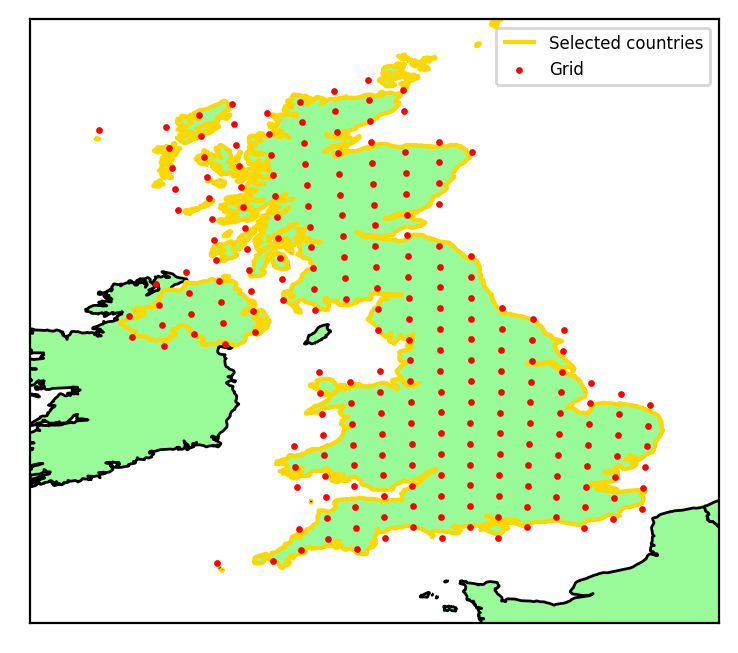

,latitude,longitude
0,50.054970,-6.387600
1,50.089233,-5.362867
2,50.293556,-4.861203
3,50.314375,-3.829999
4,50.495761,-4.355188


In [7]:
ukgrid = grd.generate_grid(
    bbox=[45, -15, 58, 15],       # Use this to clip to a bounding box as well as the countries selected
    countries=["United Kingdom"], # List as many countries as you want, or set to None for world-wide
    radial_clip=None,             # Only include search points within a certain radius of a location (see Example 3)
    buffer=0,                     # Increase this if you'd like to consider systems "near" the target region (see Example 2)
    search_radius=24.5,           # Allow some extra overlap due to inaccuracies in measuring distance
    local_crs_epsg=27700,         # EPSG:27700 is OSGB36 / British National Grid
    show=True                     # Gives a nice plot of the region and grid
)
ukgrid.head()

### Search Grid Example 2

In this example, we'll generate a grid of search points in and around Luxembourg.

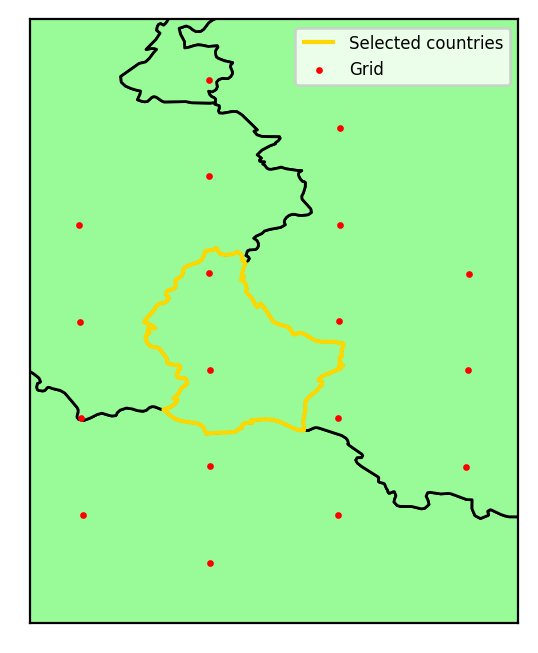

,latitude,longitude
0,48.932487,5.976485
1,49.121341,5.472296
2,49.123010,6.479236
3,49.314053,5.975016
4,49.311313,6.985824


In [8]:
luxgrid = grd.generate_grid(
    countries=["Luxembourg"],
    buffer=50,                 # Include search radii within 50km of Luzembourgs border
    search_radius=24.5,        # Allow some extra overlap due to inaccuracies in measuring distance
    local_crs_epsg=2169,       # EPSG:2169 is Luxembourg 1930 / Gauss
    show=True                  # Gives a nice plot of the region and grid
)
luxgrid.head()

### Search Grid Example 3

In this example, we'll generate a search grid for any system within 100km of Sheffield.

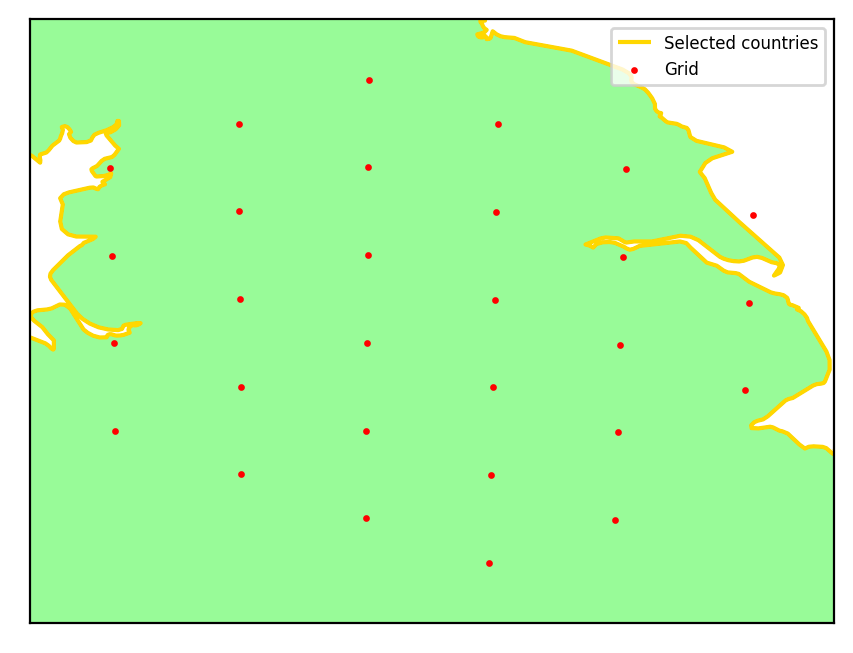

,latitude,longitude
0,52.288566,-1.152343
1,52.485870,-1.700791
2,52.477927,-0.596554
3,52.680610,-2.254144
4,52.677800,-1.144830


In [9]:
shefgrid = grd.generate_grid(
    radial_clip=(53.381, -1.486, 100.), # Only include search points within a 100km of the TUOS Physics Department
    local_crs_epsg=27700,              # EPSG:27700 is OSGB36 / British National Grid
    show=True                          # Gives a nice plot of the region and grid
)
shefgrid.head()

### Search Grid Example 4

In this example, we'll search for systems in the Balkan states surrounding Serbia...

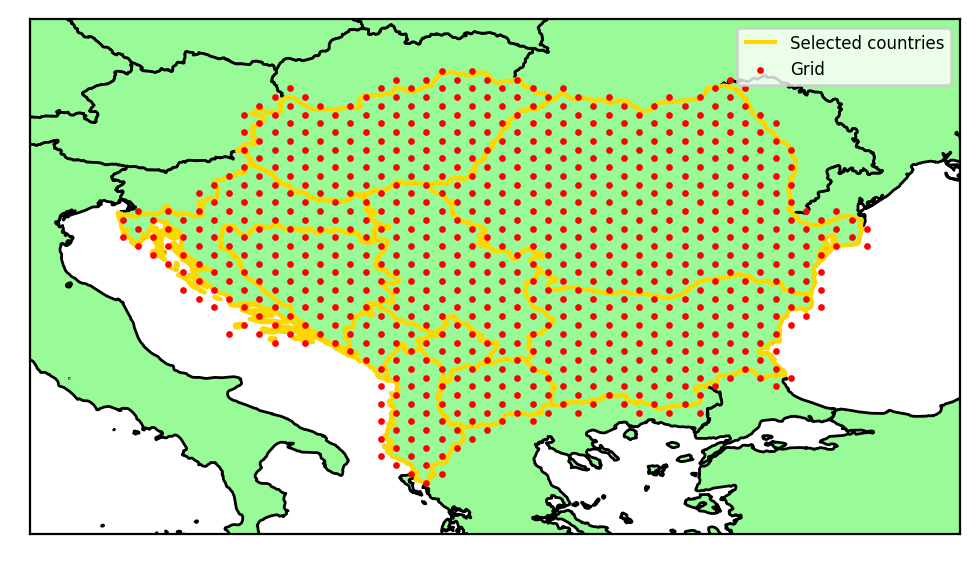

,latitude,longitude
0,39.637010,20.214141
1,39.827611,19.884010
2,39.827611,20.544272
3,40.018212,19.553879
4,40.018212,20.214141


In [10]:
balkan_grid = grd.generate_grid(
    countries=["Bosnia and Herz.", "Croatia", "Hungary", "Romania", "Bulgaria",
               "North Macedonia", "Kosovo", "Albania", "Montenegro", "Serbia"],
    search_radius=24.5,
    show=True
)
balkan_grid.head()

## Looping through grid coords and searching PVOutput for systems

Once we have the coordinates for our grid search, we can loop through them and call the `PVOutput.search()` method to find PV systems across the desired region.

Because PVOutput limits its API responses to at most 30 systems, sometimes we might need to drill-down and conduct a search with finer spatial granularity to ensure we don't miss any.

In [11]:
def search_using_grid(grid, search_radius=25):
    systems = None
    for i, loc in grid.iterrows():
        print(f"Searching for systems within {search_radius}km of {loc.latitude}, {loc.longitude} ({i} of {len(grid)})...")
        new_systems = pv.search(query=f"{search_radius}km", lat=loc.latitude, lon=loc.longitude,
                                wait_if_rate_limit_exceeded=True)
        if len(new_systems) >= 30: # PVOutput returns a maximum of 30 systems, so we'll drill down and conduct a finer search
            print("PVOutput returned 30 systems... drilling down")
            grid_ = grd.generate_grid(
                radial_clip=(loc.latitude, loc.longitude, 25),
                buffer=0,
                search_radius=5,
                show=False
            )
             # Call this function recursively with a finer search radius
            new_systems = search_using_grid(grid_, search_radius=search_radius / 5.)
        if systems is None:
            systems = new_systems
        else:
            systems = pd.concat((systems, new_systems))
        print(f"Found {len(new_systems)} new systems")
    # Remove any duplicates due to overlapping search radii
    return systems[~systems.index.duplicated()]

Searching for systems within 25km of 39.63701, 20.214140960583123 (0 of 733)...
Found 1 new systems
Searching for systems within 25km of 39.82761114488056, 19.8840100936692 (1 of 733)...
Found 0 new systems
Searching for systems within 25km of 39.82761114488056, 20.54427182749705 (2 of 733)...
Found 0 new systems
Searching for systems within 25km of 40.01821228976112, 19.553879226755278 (3 of 733)...
Found 0 new systems
Searching for systems within 25km of 40.01821228976112, 20.214140960583123 (4 of 733)...
Found 0 new systems
Searching for systems within 25km of 40.20881343464167, 19.223748359841352 (5 of 733)...
Found 0 new systems
Searching for systems within 25km of 40.20881343464167, 19.8840100936692 (6 of 733)...
Found 0 new systems
Searching for systems within 25km of 40.20881343464167, 20.54427182749705 (7 of 733)...
Found 0 new systems
Searching for systems within 25km of 40.39941457952223, 19.553879226755278 (8 of 733)...
Found 0 new systems
Searching for systems within 25km 

Found 1 new systems
Searching for systems within 25km of 41.92422373856669, 23.51544962972237 (76 of 733)...
Found 0 new systems
Searching for systems within 25km of 41.92422373856669, 24.175711363550214 (77 of 733)...
Found 0 new systems
Searching for systems within 25km of 41.92422373856669, 24.835973097378062 (78 of 733)...
Found 0 new systems
Searching for systems within 25km of 41.92422373856669, 25.49623483120591 (79 of 733)...
Found 0 new systems
Searching for systems within 25km of 41.92422373856669, 26.15649656503376 (80 of 733)...
Found 0 new systems
Searching for systems within 25km of 41.92422373856669, 26.816758298861608 (81 of 733)...
Found 0 new systems
Searching for systems within 25km of 41.92422373856669, 27.477020032689456 (82 of 733)...
Found 0 new systems
Searching for systems within 25km of 41.92422373856669, 28.1372817665173 (83 of 733)...
Found 0 new systems
Searching for systems within 25km of 42.114824883447255, 19.223748359841352 (84 of 733)...
Found 0 new sy

Found 0 new systems
Searching for systems within 25km of 42.87722946296949, 20.54427182749705 (151 of 733)...
Found 0 new systems
Searching for systems within 25km of 42.87722946296949, 21.204533561324897 (152 of 733)...
Found 0 new systems
Searching for systems within 25km of 42.87722946296949, 21.864795295152746 (153 of 733)...
Found 0 new systems
Searching for systems within 25km of 42.87722946296949, 22.525057028980594 (154 of 733)...
Found 0 new systems
Searching for systems within 25km of 42.87722946296949, 23.185318762808443 (155 of 733)...
Found 2 new systems
Searching for systems within 25km of 42.87722946296949, 23.84558049663629 (156 of 733)...
Found 0 new systems
Searching for systems within 25km of 42.87722946296949, 24.50584223046414 (157 of 733)...
Found 0 new systems
Searching for systems within 25km of 42.87722946296949, 25.166103964291988 (158 of 733)...
Found 0 new systems
Searching for systems within 25km of 42.87722946296949, 25.826365698119833 (159 of 733)...
Foun

Found 0 new systems
Searching for systems within 25km of 43.63963404249172, 17.903224892185655 (226 of 733)...
Found 0 new systems
Searching for systems within 25km of 43.63963404249172, 18.563486626013503 (227 of 733)...
Found 0 new systems
Searching for systems within 25km of 43.63963404249172, 19.223748359841352 (228 of 733)...
Found 0 new systems
Searching for systems within 25km of 43.63963404249172, 19.8840100936692 (229 of 733)...
Found 0 new systems
Searching for systems within 25km of 43.63963404249172, 20.54427182749705 (230 of 733)...
Found 0 new systems
Searching for systems within 25km of 43.63963404249172, 21.204533561324897 (231 of 733)...
Found 0 new systems
Searching for systems within 25km of 43.63963404249172, 21.864795295152746 (232 of 733)...
Found 0 new systems
Searching for systems within 25km of 43.63963404249172, 22.525057028980594 (233 of 733)...
Found 0 new systems
Searching for systems within 25km of 43.63963404249172, 23.185318762808443 (234 of 733)...
Foun

Found 0 new systems
Searching for systems within 25km of 44.211437477133394, 24.175711363550214 (300 of 733)...
PVOutput.org API rate limit exceeded!  Rate limit will be reset at 2021-11-22 17:00:00+00:00
Waiting 1606 seconds.  Will retry at 2021-11-22 17:03:00+00:00
Found 0 new systems
Searching for systems within 25km of 44.211437477133394, 24.835973097378062 (301 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.211437477133394, 25.49623483120591 (302 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.211437477133394, 26.15649656503376 (303 of 733)...
Found 1 new systems
Searching for systems within 25km of 44.211437477133394, 26.816758298861608 (304 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.211437477133394, 27.477020032689456 (305 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.211437477133394, 28.1372817665173 (306 of 733)...
Found 1 new systems
Searching for systems within 25km of 44.2114

Found 0 new systems
Searching for systems within 25km of 44.78324091177506, 27.14688916577553 (373 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.78324091177506, 27.80715089960338 (374 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.78324091177506, 28.467412633431227 (375 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.78324091177506, 29.12767436725908 (376 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.78324091177506, 29.787936101086924 (377 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.97384205665563, 13.611523622304642 (378 of 733)...
Found 1 new systems
Searching for systems within 25km of 44.97384205665563, 14.271785356132492 (379 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.97384205665563, 14.932047089960339 (380 of 733)...
Found 0 new systems
Searching for systems within 25km of 44.97384205665563, 15.592308823788185 (381 of 733)...
Foun

Found 0 new systems
Searching for systems within 25km of 45.35504434641674, 26.816758298861608 (448 of 733)...
Found 0 new systems
Searching for systems within 25km of 45.35504434641674, 27.477020032689456 (449 of 733)...
Found 0 new systems
Searching for systems within 25km of 45.35504434641674, 28.1372817665173 (450 of 733)...
Found 0 new systems
Searching for systems within 25km of 45.35504434641674, 28.79754350034515 (451 of 733)...
Found 0 new systems
Searching for systems within 25km of 45.35504434641674, 29.457805234172998 (452 of 733)...
Found 0 new systems
Searching for systems within 25km of 45.54564549129729, 13.941654489218566 (453 of 733)...
Found 13 new systems
Searching for systems within 25km of 45.54564549129729, 14.601916223046414 (454 of 733)...
Found 0 new systems
Searching for systems within 25km of 45.54564549129729, 15.262177956874261 (455 of 733)...
Found 0 new systems
Searching for systems within 25km of 45.54564549129729, 15.922439690702113 (456 of 733)...
Fou

Found 1 new systems
Searching for systems within 25km of 46.11744892593897, 19.553879226755278 (523 of 733)...
Found 0 new systems
Searching for systems within 25km of 46.11744892593897, 20.214140960583123 (524 of 733)...
Found 2 new systems
Searching for systems within 25km of 46.11744892593897, 20.87440269441097 (525 of 733)...
Found 0 new systems
Searching for systems within 25km of 46.11744892593897, 21.53466442823882 (526 of 733)...
Found 1 new systems
Searching for systems within 25km of 46.11744892593897, 22.194926162066672 (527 of 733)...
Found 0 new systems
Searching for systems within 25km of 46.11744892593897, 22.85518789589452 (528 of 733)...
Found 0 new systems
Searching for systems within 25km of 46.11744892593897, 23.51544962972237 (529 of 733)...
Found 1 new systems
Searching for systems within 25km of 46.11744892593897, 24.175711363550214 (530 of 733)...
Found 0 new systems
Searching for systems within 25km of 46.11744892593897, 24.835973097378062 (531 of 733)...
Found

Found 1 new systems
Searching for systems within 25km of 46.8798535054612, 18.89361749292743 (597 of 733)...
Found 2 new systems
Searching for systems within 25km of 46.8798535054612, 19.553879226755278 (598 of 733)...
Found 4 new systems
Searching for systems within 25km of 46.8798535054612, 20.214140960583123 (599 of 733)...
Found 1 new systems
Searching for systems within 25km of 46.8798535054612, 20.87440269441097 (600 of 733)...
PVOutput.org API rate limit exceeded!  Rate limit will be reset at 2021-11-22 18:00:00+00:00
Waiting 3437 seconds.  Will retry at 2021-11-22 18:03:00+00:00
Found 0 new systems
Searching for systems within 25km of 46.8798535054612, 21.53466442823882 (601 of 733)...
Found 0 new systems
Searching for systems within 25km of 46.8798535054612, 22.194926162066672 (602 of 733)...
Found 0 new systems
Searching for systems within 25km of 46.8798535054612, 22.85518789589452 (603 of 733)...
Found 0 new systems
Searching for systems within 25km of 46.8798535054612, 23.

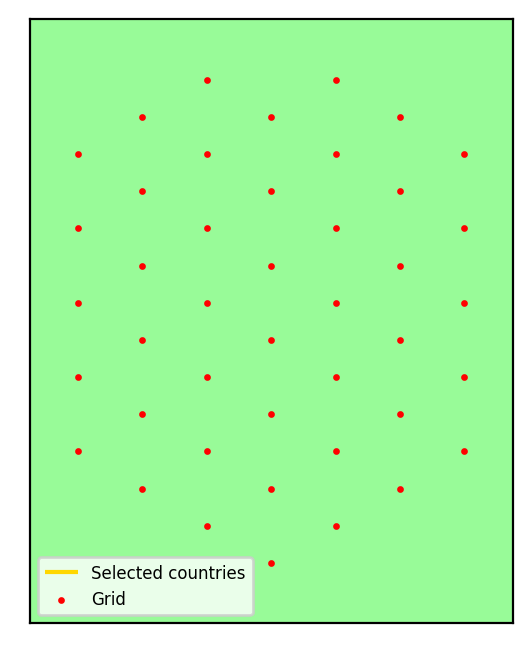

Searching for systems within 5.0km of 47.18818180716722, 19.22374882102988 (0 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.22707999999999, 19.156375174720914 (1 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.22707999999999, 19.291122467338845 (2 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.265978192832755, 19.08900152841195 (3 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.265978192832755, 19.22374882102988 (4 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.265978192832755, 19.358496113647806 (5 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.30487638566552, 19.021627882102987 (6 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.30487638566552, 19.156375174720914 (7 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.30487638566552, 19.291122467338845 (8 of 43)...
Found 0 new systems
Searching for syste

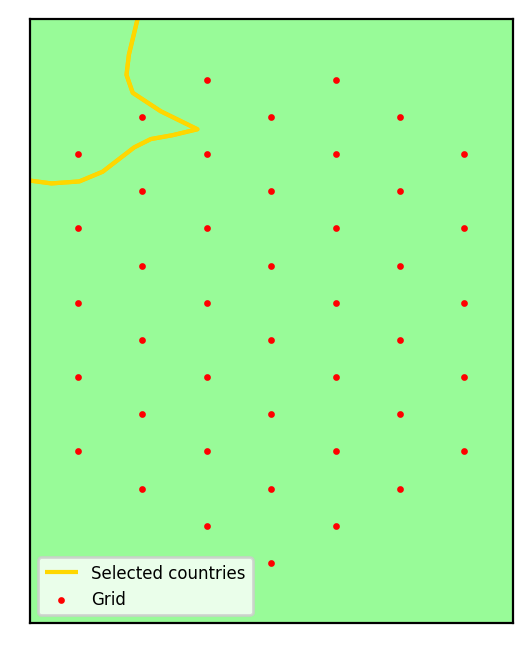

Searching for systems within 5.0km of 47.378781807167215, 18.893618821029875 (0 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.41767999999998, 18.826245174720913 (1 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.41767999999998, 18.96099246733884 (2 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.45657819283275, 18.758871528411948 (3 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.45657819283275, 18.893618821029875 (4 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.45657819283275, 19.028366113647802 (5 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.49547638566551, 18.691497882102986 (6 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.49547638566551, 18.826245174720913 (7 of 43)...
Found 0 new systems
Searching for systems within 5.0km of 47.49547638566551, 18.96099246733884 (8 of 43)...
Found 0 new systems
Searching for system

Found 2 new systems
Searching for systems within 25km of 48.02346037474455, 18.89361749292743 (703 of 733)...
Found 1 new systems
Searching for systems within 25km of 48.02346037474455, 19.553879226755278 (704 of 733)...
Found 2 new systems
Searching for systems within 25km of 48.02346037474455, 20.214140960583123 (705 of 733)...
Found 1 new systems
Searching for systems within 25km of 48.02346037474455, 20.87440269441097 (706 of 733)...
Found 9 new systems
Searching for systems within 25km of 48.02346037474455, 21.53466442823882 (707 of 733)...
Found 2 new systems
Searching for systems within 25km of 48.02346037474455, 22.194926162066672 (708 of 733)...
Found 2 new systems
Searching for systems within 25km of 48.02346037474455, 22.85518789589452 (709 of 733)...
Found 0 new systems
Searching for systems within 25km of 48.02346037474455, 23.51544962972237 (710 of 733)...
Found 0 new systems
Searching for systems within 25km of 48.02346037474455, 24.175711363550214 (711 of 733)...
Found 

In [12]:
systems = search_using_grid(balkan_grid)
systems.to_csv("PVOutput_Balkan_systems.csv")

## Inspect the results

In [13]:
systems = pd.read_csv("PVOutput_Balkan_systems.csv", index_col="system_id")

In [14]:
systems.head()

,name,system_DC_capacity_W,address,orientation,num_outputs,last_output,panel,inverter,distance_km,latitude,longitude
system_id,,,,,,,,,,,
8326,MITSIONIS,9870,Greece,S,3096,Yesterday,SANYO HIT 235,SMA 10000TL,16.1,39.500010,20.273735
8212,Ilias Dytiko GR,9945,Greece,N,1484,283 weeks ago,Luxor,SMA TRIPOWER 10000TL,12.3,40.860695,22.526426
61962,Mcalona,121765,Greece,S,1179,Yesterday,Various,Various,23.2,40.783954,22.402208
61423,Bicaku,110880,Albania,S,1089,Yesterday,Luxor Secure Line,SolarEdge,19.3,41.326586,19.482591
25128,demetrios PV,10000,Greece,S,485,290 weeks ago,canadian,SMA,8.6,41.086889,23.542039


In [15]:
def plot_systems(systems):
    """Plot the systems' locations."""
    # Get some nice world boundaries
    world, _ = grd.nat_earth.get_hires_world_boundaries()
    # Create an empty figure
    f, ax = plt.subplots()
    # Plot the world boundaries
    world.plot(ax=ax, color="palegreen", edgecolor="black", linewidth=1, label="World")
    # Prep the systems for plotting
    coords = gpd.GeoDataFrame(systems, geometry=gpd.points_from_xy(systems.longitude, systems.latitude))
    coords = coords.set_crs("EPSG:4326").to_crs("EPSG:4087")
    # Plot the systems
    coords.plot(ax=ax, marker="o", color="slategray", markersize=2, label="Systems")
    # Figure out the axes bounds
    xmin = coords.geometry.bounds.minx.min()
    xmax = coords.geometry.bounds.maxx.max()
    ymin = coords.geometry.bounds.miny.min()
    ymax = coords.geometry.bounds.maxy.max()
    xpadding = (xmax - xmin) / 8
    ypadding = (ymax - ymin) / 8
    ax.set_xlim(xmin - xpadding, xmax + xpadding)
    ax.set_ylim(ymin - ypadding, ymax + ypadding)
    # Hide the axis labels
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # Add a legend
    plt.legend()
    # Show the plot
    plt.show()

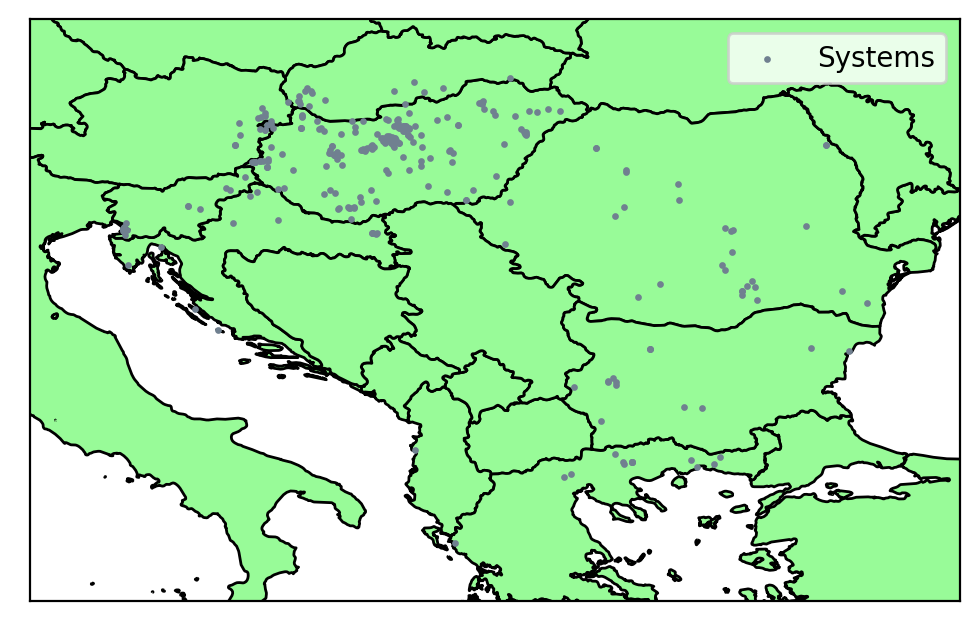

In [16]:
plot_systems(systems)

## Extract system metadata

Remove any systems with fewer than 50 outputs

In [17]:
systems = systems.query("num_outputs >= 50")
systems.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 8326 to 65752
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   name                  225 non-null    object  
 1   system_DC_capacity_W  225 non-null    int64   
 2   address               225 non-null    object  
 3   orientation           225 non-null    object  
 4   num_outputs           225 non-null    int64   
 5   last_output           225 non-null    object  
 6   panel                 218 non-null    object  
 7   inverter              225 non-null    object  
 8   distance_km           225 non-null    float64 
 9   latitude              225 non-null    float64 
 10  longitude             225 non-null    float64 
 11  geometry              225 non-null    geometry
dtypes: float64(3), geometry(1), int64(2), object(6)
memory usage: 22.9+ KB


Fetch the system metadata

In [18]:
get_metadata = lambda system_id: pv.get_metadata(system_id, wait_if_rate_limit_exceeded=True)
metadata = systems.reset_index().system_id.apply(get_metadata)
metadata.to_csv("PVOutput_Balkan_systems_metadata.csv")
metadata.head()

PVOutput.org API rate limit exceeded!  Rate limit will be reset at 2021-11-22 19:00:00+00:00
Waiting 3379 seconds.  Will retry at 2021-11-22 19:03:00+00:00


,name,system_DC_capacity_W,address,num_panels,panel_capacity_W_each,panel_brand,num_inverters,inverter_capacity_W,inverter_brand,orientation,...,shade,install_date,latitude,longitude,status_interval_minutes,secondary_num_panels,secondary_panel_capacity_W_each,secondary_orientation,secondary_array_tilt_degrees,system_id
0,MITSIONIS,9870,NaN,42,235,SANYO HIT 235,1,100,SMA 10000TL,S,...,Low,2012-05-22,39.500010,20.273735,5,0,0,NaN,NaN,8326
1,Ilias Dytiko GR,9945,NaN,51,195,Luxor,1,10000,SMA TRIPOWER 10000TL,N,...,No,2012-05-18,40.860695,22.526426,5,0,0,NaN,NaN,8212
2,Mcalona,121765,NaN,497,245,Various,1,102000,Various,S,...,No,NaT,40.783954,22.402208,5,0,0,NaN,NaN,61962
3,Bicaku,110880,NaN,396,280,Luxor Secure Line,3,27600,SolarEdge,S,...,No,2018-06-01,41.326586,19.482591,5,0,0,NaN,NaN,61423
4,demetrios PV,10000,NaN,40,250,canadian,1,10000,SMA,S,...,No,2012-10-04,41.086889,23.542039,10,0,0,NaN,NaN,25128


## Command line interface for `GridSearch.generate_grid()`

There's also a command line interface that can be used to generate a grid and save the point locations to a file:

```
>> python pvoutput/grid_search.py -h
usage: grid_search.py [-h] [--bbox <min_lat,min_lon,max_lat,max_lon>]
                      [--countries <country>[,<country>[,...]]] [--radial-clip <lat,lon,radius_km>]
                      [--list-countries] [--buffer <buffer>] [--search-radius <radius>]
                      [--local-crs-epsg <EPSG>] [--cache-dir </path/to/dir>] [--show] [-o <path>]

This is a command line interface (CLI) for the grid_search module.

optional arguments:
  -h, --help            show this help message and exit
  --bbox <min_lat,min_lon,max_lat,max_lon>
                        Specify a bounding box to search. Can be used in conjunction with --countries
  --countries <country>[,<country>[,...]]
                        Specify a list of countries, searching only grid points that fall within these
                        countries' boundaries. Specify one or more countries, separated by commas (default
                        is all). Country names must match those used in the Natural Earth dataset (HINT: run
                        this code with the --list-countries option to list them). This option can be used in
                        conjunction with --bbox, in which case the search will only include grid points
                        within both the bounding box and the countries list.
  --radial-clip <lat,lon,radius_km>
                        Specify a radius to clip to. Can be used in conjunction with --bbox and --countries.
                        Pass the latitude, longitude and radius as a comma-separated string. Radius should
                        be in km.
  --list-countries      List the country names that can be used for the --countries option.
  --buffer <buffer>     Specify a buffer/tolerance for including grid points i.e. include grid points that
                        fall within <buffer> kilometers of the target boundary. Default is 0km.
  --search-radius <radius>
                        Specify the radial search limit around each grid point in kilometers.
  --local-crs-epsg <EPSG>
                        Optionally provide the EPSG code of a local co-ordinate Reference System (CRS) for
                        improved accuracy. e.g. set to 27700 (OSGB36 / British National Grid) if searching
                        the British Isles.
  --cache-dir </path/to/dir>
                        Specify a directory to use for caching downloaded boundary files.
  --show                Set this flag to show a plot of the grid.
  -o <path>, --outfile <path>
                        Specify a filename to save the grid to.

Jamie Taylor, 2021-11-16
```